# 3D image classification using CNN's code along

here in this task I code along with the keras code example.

## Imports used for this task

In [7]:
import os
import zipfile
import numpy as np
import tensorflow as tf  # for data preprocessing
import nibabel as nib
import random
import matplotlib.pyplot as plt
from scipy import ndimage
import keras
from keras import layers

## Downloading the data sets

from: https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1

we plan to build a binary classification task, where given sets of healthy CT scans and abnormal CT scans we can classify some unseen scans.

We can do this by downloading both the respective normal and abnormal data, unzipping the files into the MosMetaData directory

In [3]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

1065471431/1065471431 ━━━━━━━━━━━━━━━━━━━━ 110s 0us/step
1045162547/1045162547 ━━━━━━━━━━━━━━━━━━━━ 109s 0us/step


In [5]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


what we can see, is that this data is in an unusual format (for me at least) being in NIfTI (Neuroimaging Informatics Technology Initiative). This is used for most CTs. To handle this data it is recommended to use the nibabel package.

We can first begin by reading the file with this nibabel package. We note that CT scans store voxel intensities, voxels are simply 3d pixels represented as cubes. 

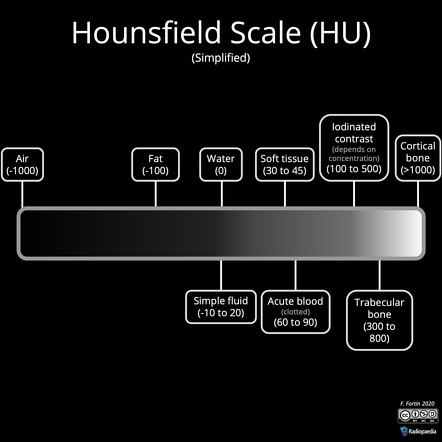

as we can see bone starts at around 300 HU. We note that as we can see from this diagram, we have -1000 HU which would represent air, and anything above 300 represents types of Bone. Hence when looking to normalise our dataset it may be a good idea to normalise wrt these min max values of -1000 and some difinitive value of bone. As the vast majority of bone falls between 400-800 VU we can use some number in this range to normalise with, lets use 600 to be safe.

After we have performed this normalization, we can then resize the volume, we can do this by taking as input the desired dimnensions of the CT scan and use these factors in order to locate the 

In [4]:
def read_nifti_file(filepath):
    # Read file
    scan = nib.load(filepath)
    
    # Get raw data
    scan = scan.get_fdata()
    
    return scan


def normalize(volume, min_val, max_val):
    
    #filter all values out less than the min value and set it to the min val
    #eg filter all values out which have a HU less than air
    volume[volume < min_val] = min_val
    
    #filter all values out larger than the max value and set it to the max val
    #eg filter all values out that are cortical bone
    volume[volume > max_val] = max_val
    
    #perform the normalization ensuring that all values are between 0,1
    volume = (volume - min_val) / (max_val - min_val)
    
    #adjust the dtype of our volume
    volume = volume.astype("float32")
    return volume


def resize_volume(img, desired_depth=64, desired_width = 128, desired_height = 128):
    
    # Get current depth, we do this by collecting the depth width and heigh dimensions via the shape function
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    # Compute the factor, we can do this by finding the ratio between the actual depth/width/height and the desired.
    #by finding the reciprical of these values we return the factor which we can use in our rotation matrices
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    # Rotate the image to ensure we have a formal standadization of orientation
    img = ndimage.rotate(img, 90, reshape=False)
    
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume, -1000, 800)#can use 400
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

We can now go through each CT in both the testing and training data sets and use this process scan function above to read the file, normlize and resize

In [8]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

Now that we have processed binary classifications we can simplify this process, by classifying normal and abnormal scans with labels of 0 and 1 respectivley.

In [9]:
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

Now that we have both the scans ready and the labels ready, we can now beign to split the data into testing and training, as we only have 100 scans each we will be going from 85, 15 training testing.

In [10]:
x_train = np.concatenate((abnormal_scans[:85], normal_scans[:85]), axis=0)
y_train = np.concatenate((abnormal_labels[:85], normal_labels[:85]), axis=0)

x_val = np.concatenate((abnormal_scans[85:], normal_scans[85:]), axis=0)
y_val = np.concatenate((abnormal_labels[85:], normal_labels[85:]), axis=0)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 170 and 30.


We note that with only 100 examples, to make a predictions we will fall into the pitfall of overfitting. One of the classic techniques to combat overfitting is to ensure there is simply enough datasets to train with, as this should ensure no bias is being built for a particular set of training data. To do this we can augment the data by rotating the datasets in a random manner and adding these new randomly rotated/translated datasets to our training data.

In [13]:
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    
    #This is a TensorFlow function that allows you to wrap a Python function and use it within a TensorFlow computation graph.
    #as we will be using this rotation inside the train loader in tensorflow, it is  a computational graph, hence we can incorparate it
    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

Below we can create data loaders which can be used for the CNN we will define

In [14]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

We can then create our resepctive testing and training datasets from the loaders we created above.

We first take our data from the loaders we have created and shuffle the data around whilst maintaining pairwise order.
We can then apply to each scan in our dataset the preprocessing of the rotation on the dataset via the .map() function.
We also batch our data into 2 groups (as we have a small dataset this size seems reasonable).
Finally we can prefetch batches from the datasets to improve the performance, where we allow 2 batches to be collected in advance

In [15]:
batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Now that our testing and training datasets are ready we can createe our model. We use a structure of a 3d convolution later followed by a pooling layer and a normalization. This process repeates, below is an example of the structure of our network 

In [16]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 64, 1)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 126, 126, 62, 64)    │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 63, 63, 31, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 31, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 61, 61, 29, 64)      │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 30, 30, 14, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 14, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 28, 28, 12, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 14, 14, 6, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 6, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 12, 12, 4, 256)      │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 6, 6, 2, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 2, 256)        │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

We can now begin to train our model, we can us a learning rate schedule, which allows us to anneal the learning rate over time, essentially adjusting the lr as our model learns. In this example the strategy that we use is exponential decay.

We also use the Adam optimizer as it allows for the adaptive learning rates and the factoring in of momentum, which is the technique of accumulating the gradients from previous iterations. (this is possible is sgd as well)

We also use an early stopping criterion to improve generalization (decrease overfitting) by stopping the training process when the validation accuracy stops improving, in this case we have a patience of 15 epochs, where after 15 epochs, if we do not see a change in accuracy stop the training early.

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
85/85 - 668s - 8s/step - acc: 0.5647 - loss: 0.6793 - val_acc: 0.5000 - val_loss: 1.1517
Epoch 2/100


now that we have a trained model, lets make predictions with the model below

In [ ]:
# Load best weights.
model.load_weights("3d_image_classification.keras")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )